### Importing Dependencies


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import sklearn
import os, pathlib
import kaggle, kagglehub


### Downloading the competition


In [2]:
competition_name = (
    "playground-series-s5e1"  # Change this to the competition you want to download
)
competition_path = pathlib.Path(
    kagglehub.competition.competition_download(competition_name)
)  # Downloads the competition
competition_files: list = os.listdir(
    competition_path
)  # List of the files included in the competition

print(competition_files)

['sample_submission.csv', 'test.csv', 'train.csv']


In [18]:
pl.Config.set_tbl_rows(40)  # polars config set number of rows to display

train_df = pl.read_csv(competition_path / "train.csv")
test_df = pl.read_csv(competition_path / "test.csv")
sample_submission_df = pl.read_csv(competition_path / "sample_submission.csv")

test_df = test_df.with_columns(pl.lit(None).alias("num_sold"))

train_last_row_idx = train_df.height - 1
train_df[train_last_row_idx]


id,date,country,store,product,num_sold
i64,str,str,str,str,f64
230129,"""2016-12-31""","""Singapore""","""Premium Sticker Mart""","""Kerneler Dark Mode""",1622.0


In [19]:
df = pl.concat([train_df, test_df]).with_columns(
    [
        pl.col("id").cast(pl.UInt32),
        pl.col("date").cast(pl.Date),
        pl.col("country").cast(pl.Categorical),
        pl.col("store").cast(pl.Categorical),
        pl.col("product").cast(pl.Categorical),
        pl.col("num_sold").cast(pl.UInt16),
    ]
)



In [20]:
df = pl.concat(
    [df,
     df['country'].to_dummies(),
     df['store'].to_dummies(),
     df['product'].to_dummies()],
    how='horizontal')
df = df.with_columns([
    ((pl.col('date').dt.year() - 2009) / 10).alias('year'),
    (np.sin(2 * np.pi * pl.col("date").dt.month() / 12)).alias("month_sin"),
    (np.sin(2 * np.pi * pl.col("date").dt.day() / 31)).alias("day_sin"),
    (np.sin(2 * np.pi * pl.col("date").dt.weekday() / 7)).alias("weekday_sin"),
    (np.sin(2 * np.pi * pl.col("date").dt.ordinal_day() / 366)).alias("ordinal_day_sin"),
    (np.sin(2 * np.pi * pl.col("date").dt.week() / 53)).alias("week_sin")
])


In [21]:
max_num_sold: int = df['num_sold'].max()  # Using Max value of `num_sold` for scaling

df.with_columns([
    (pl.col('num_sold') / max_num_sold).alias('num_sold_scaled')
])

id,date,country,store,product,num_sold,country_Canada,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode,year,month_sin,day_sin,weekday_sin,ordinal_day_sin,week_sin,num_sold_scaled
u32,date,cat,cat,cat,u16,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,f64,f64,f64,f64,f64,f64,f64
0,2010-01-01,"""Canada""","""Discount Stickers""","""Holographic Goose""",null,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,null
1,2010-01-01,"""Canada""","""Discount Stickers""","""Kaggle""",973,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.163832
2,2010-01-01,"""Canada""","""Discount Stickers""","""Kaggle Tiers""",906,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.152551
3,2010-01-01,"""Canada""","""Discount Stickers""","""Kerneler""",423,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.071224
4,2010-01-01,"""Canada""","""Discount Stickers""","""Kerneler Dark Mode""",491,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.082674
5,2010-01-01,"""Canada""","""Stickers for Less""","""Holographic Goose""",300,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.050514
6,2010-01-01,"""Canada""","""Stickers for Less""","""Kaggle""",1837,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.309311
7,2010-01-01,"""Canada""","""Stickers for Less""","""Kaggle Tiers""",1659,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.27934
8,2010-01-01,"""Canada""","""Stickers for Less""","""Kerneler""",807,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0.1,0.5,0.201299,-0.974928,0.017166,-2.4493e-16,0.135881


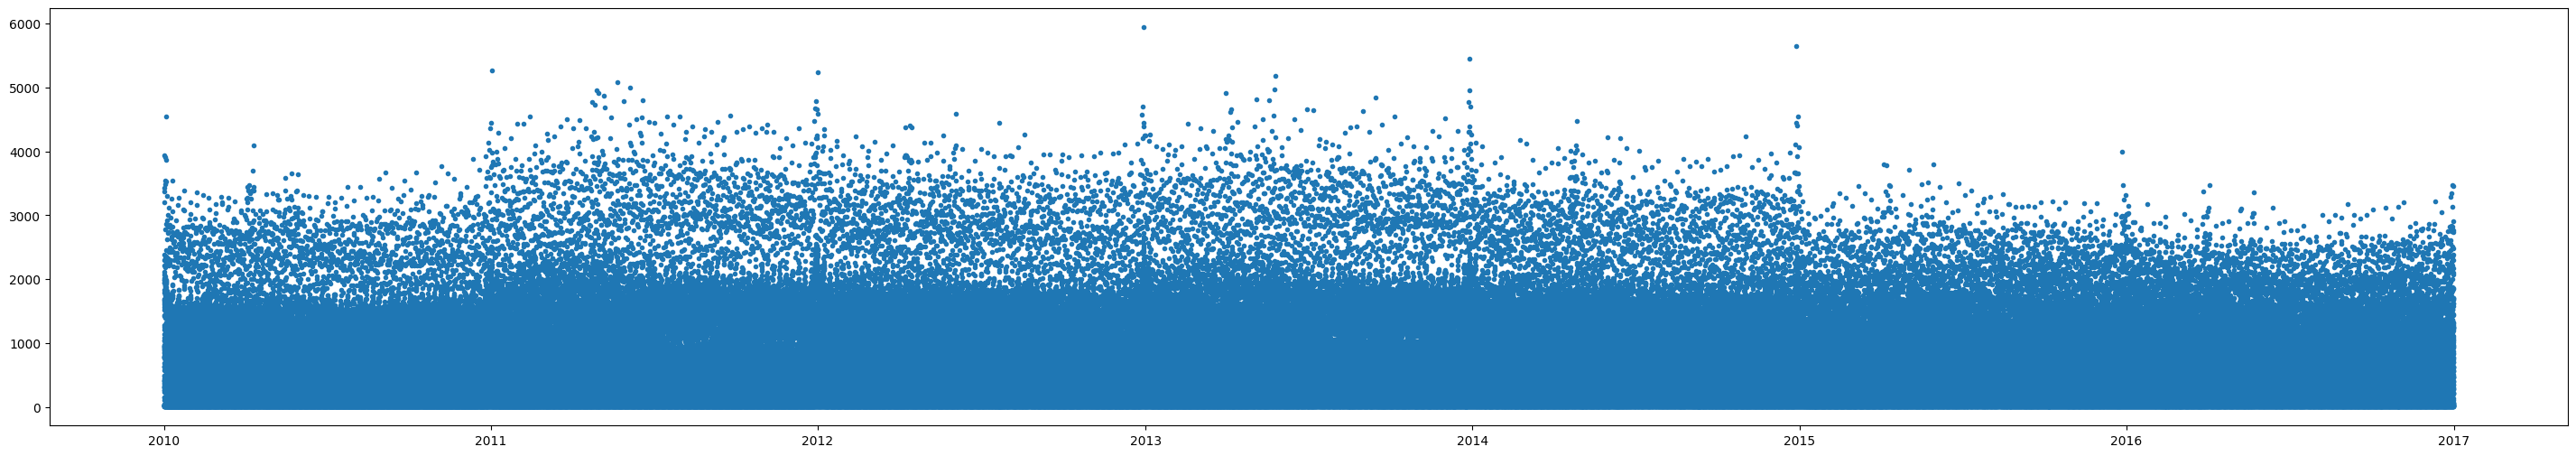

In [7]:
plt.figure(figsize=(36, 6))
plt.scatter(df['date'], df['num_sold'], marker='.')

In [30]:
df.write_parquet('./exported_df.parquet')

In [25]:
df_train = df[:train_last_row_idx + 1]
df_test = df[train_last_row_idx + 1:]
print(df_train[-1], df_test[0])

In [29]:
df_train.write_parquet('train_preprocessed.parquet')
df_test.write_parquet('test_preprocessed.parquet')